In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
%%writefile basic_chatbot.py

from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

Writing basic_chatbot.py


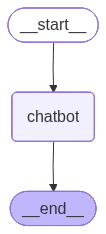

In [4]:
from basic_chatbot import graph

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hi! How can I help you today?
Assistant: To add tools in LangGraph, you can follow these steps:

1. First, define your tools as functions or classes that implement the functionality you need.
2. Create a ToolExecutor to manage your tools.
3. Add the tools to your graph's nodes where they're needed.

Here's an example:

```python
from typing import Annotated, TypedDict
from langgraph.prebuilt import ToolExecutor
from langchain_core.tools import tool
from langgraph.graph import END, Graph

# 1. Define your tools
@tool
def search_tool(query: str) -> str:
    """Search for information about a query."""
    # Implement search logic here
    return f"Search results for: {query}"

@tool
def calculator(expression: str) -> str:
    """Calculate mathematical expressions."""
    try:
        return str(eval(expression))
    except:
        return "Could not calculate expression"

# 2. Create a ToolExecutor
tools = [search_tool, calculator]
tool_executor = ToolExecutor(tools)

# 3. Defi